## TEST

In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Gabungkan semua variabel independen
X = data[['Upah_Minimum', 'Pendapatan', 'Nilai_Produksi', 'Jumlah_Angkatan_Kerja', 'TPAK']]
X = sm.add_constant(X)

# Hitung VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


                 feature         VIF
0                  const  586.166288
1           Upah_Minimum    3.886274
2             Pendapatan    1.055774
3         Nilai_Produksi    2.525693
4  Jumlah_Angkatan_Kerja    4.966080
5                   TPAK    1.125401


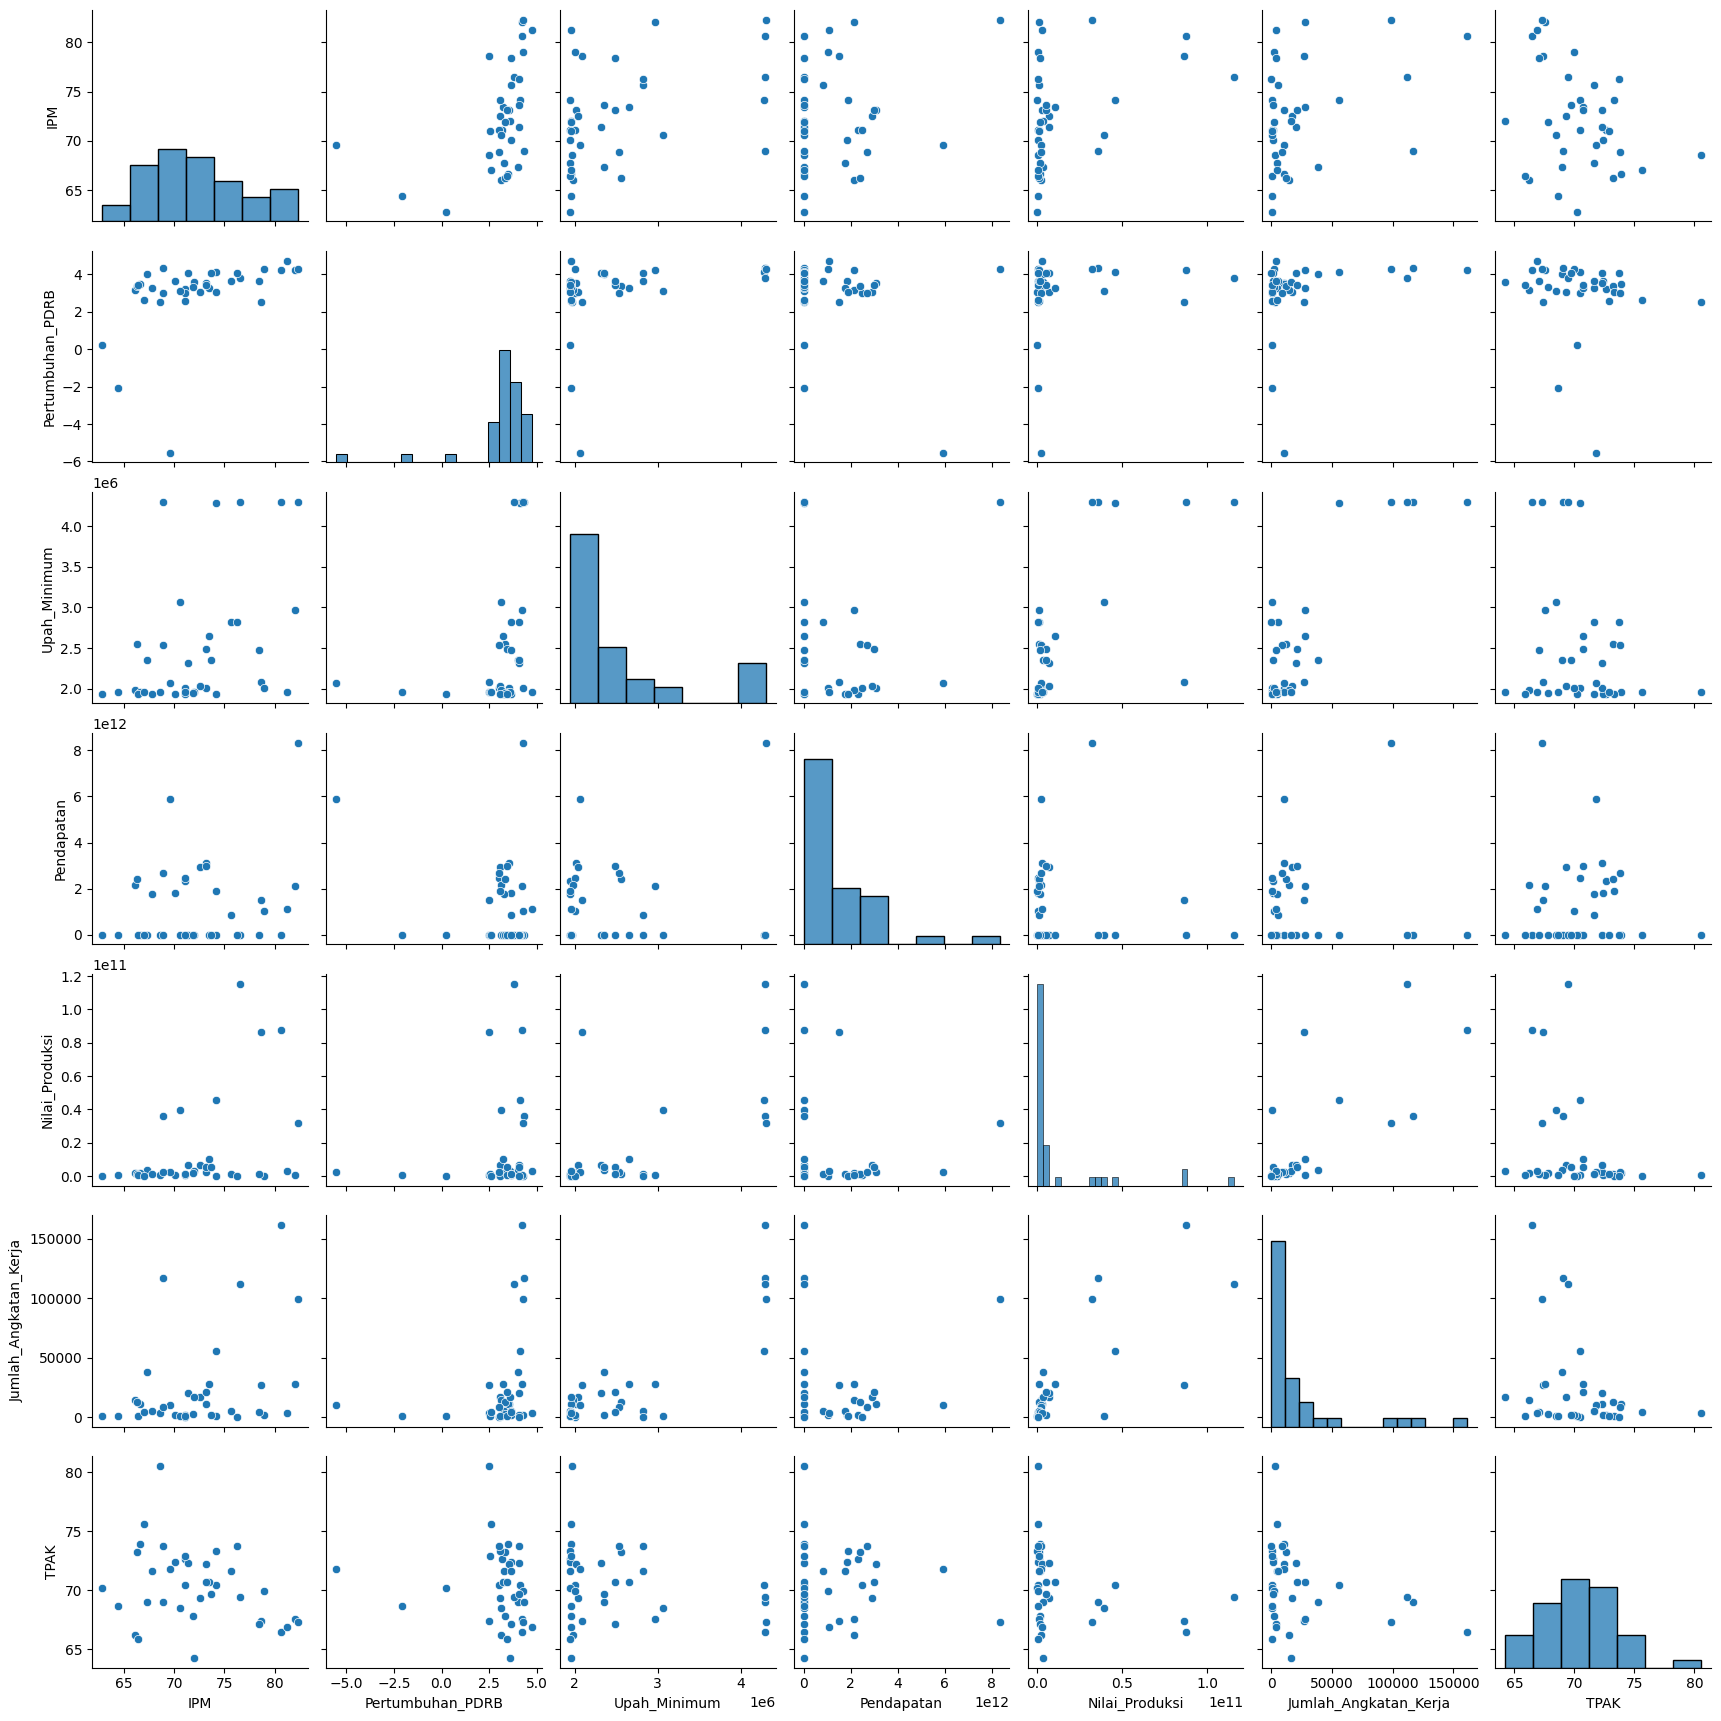

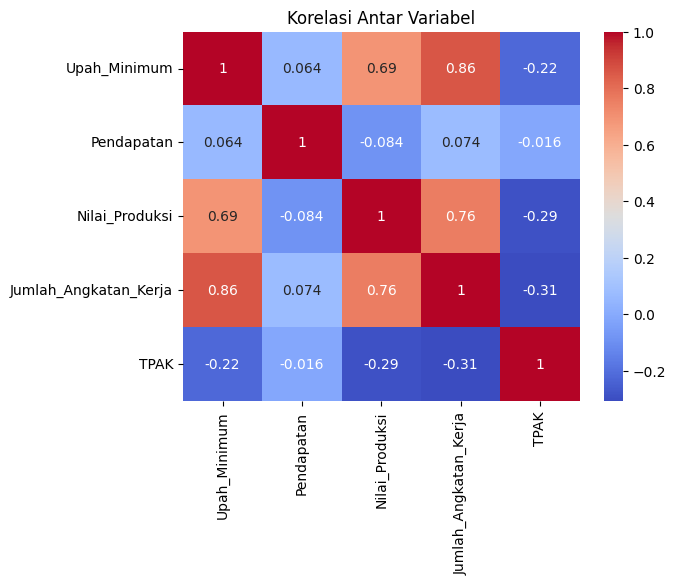

Breusch-Pagan Test Model Y1 (IPM):
LM statistic = 7.6100, p-value = 0.1791

Breusch-Pagan Test Model Y2 (Pertumbuhan PDRB):
LM statistic = 5.5945, p-value = 0.3477

Durbin-Watson Test Y1 (IPM): 0.8418
Durbin-Watson Test Y2 (Pertumbuhan PDRB): 1.4782

                           System GLS Estimation Summary                           
Estimator:                        GLS   Overall R-squared:                   0.2253
No. Equations.:                     2   McElroy's R-squared:                 0.1416
No. Observations:                  38   Judge's (OLS) R-squared:             0.2253
Date:                Fri, Nov 29 2024   Berndt's R-squared:                  0.2314
Time:                        23:26:29   Dhrymes's R-squared:                 0.2253
                                        Cov. Estimator:                      robust
                                        Num. Constraints:                      None
                   Equation: Persamaan_1, Dependent Variable: IPM            

In [41]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from linearmodels.system import SUR
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor


# 1. Membaca dan membersihkan data
data = pd.read_csv('sur_dataset.csv')
data.rename(columns={
    'Kabupaten/Kota': 'Kabupaten',
    'Laju Pertumbuhan Produk Domestik Bruto/Produk Domestik Regional Bruto': 'Pertumbuhan_PDRB',
    'IPM': 'IPM',
    'Upah Minimum': 'Upah_Minimum',
    'Pendapatan Daerah': 'Pendapatan',
    'Nilai Produksi': 'Nilai_Produksi',
    'Jumlah Angkatan Kerja': 'Jumlah_Angkatan_Kerja',
    'TPAK': 'TPAK'
}, inplace=True)

# 2. Uji Linearitas
sns.pairplot(data[['IPM', 'Pertumbuhan_PDRB', 'Upah_Minimum', 'Pendapatan', 'Nilai_Produksi', 'Jumlah_Angkatan_Kerja', 'TPAK']])
plt.show()

# Korelasi antar variabel
correlation_matrix = data[['Upah_Minimum', 'Pendapatan', 'Nilai_Produksi', 'Jumlah_Angkatan_Kerja', 'TPAK']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Korelasi Antar Variabel')
plt.show()

X = data[['Upah_Minimum', 'Pendapatan', 'Nilai_Produksi', 'Jumlah_Angkatan_Kerja', 'TPAK']]
X = sm.add_constant(X)

# Hitung VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
# 3. Uji Heteroskedastisitas (Breusch-Pagan Test) untuk Y1 dan Y2
def breusch_pagan_test(model, model_name):
    residuals = model.resid
    exog = model.model.exog
    bp_test = het_breuschpagan(residuals, exog)
    print(f"Breusch-Pagan Test {model_name}:")
    print(f"LM statistic = {bp_test[0]:.4f}, p-value = {bp_test[1]:.4f}\n")

# Model awal untuk uji heteroskedastisitas
ols_y1 = smf.ols('IPM ~ Upah_Minimum + Pendapatan + Nilai_Produksi + Jumlah_Angkatan_Kerja + TPAK', data=data).fit()
ols_y2 = smf.ols('Pertumbuhan_PDRB ~ Upah_Minimum + Pendapatan + Nilai_Produksi + Jumlah_Angkatan_Kerja + TPAK', data=data).fit()

breusch_pagan_test(ols_y1, "Model Y1 (IPM)")
breusch_pagan_test(ols_y2, "Model Y2 (Pertumbuhan PDRB)")

# 4. Uji Autokorelasi (Durbin-Watson Test)
dw_y1 = durbin_watson(ols_y1.resid)
dw_y2 = durbin_watson(ols_y2.resid)
print(f"Durbin-Watson Test Y1 (IPM): {dw_y1:.4f}")
print(f"Durbin-Watson Test Y2 (Pertumbuhan PDRB): {dw_y2:.4f}\n")

# 5. Pemodelan SUR dengan variabel terpilih
# Transformasi log untuk beberapa variabel
data['Log_Upah_Minimum'] = np.log(data['Upah_Minimum'])
data['Log_Pendapatan'] = np.log(data['Pendapatan'] + 1)
data['Log_Nilai_Produksi'] = np.log(data['Nilai_Produksi'] + 1)

# Definisikan persamaan 1 (IPM)
exog_1 = sm.add_constant(data[['Log_Upah_Minimum', 'TPAK']])
endog_1 = data['IPM']

# Definisikan persamaan 2 (Pertumbuhan PDRB)
exog_2 = sm.add_constant(data[['Log_Pendapatan', 'Log_Nilai_Produksi']])
endog_2 = data['Pertumbuhan_PDRB']

# Gabungkan untuk SUR
sur_data = {
    'Persamaan_1': (endog_1, exog_1),
    'Persamaan_2': (endog_2, exog_2)
}

# Model SUR
model_sur = SUR(sur_data)
result_sur = model_sur.fit()

# Output hasil SUR
print(result_sur)

# 6. Interpretasi R-squared untuk kedua model
residuals_y1 = result_sur.resids['Persamaan_1']
residuals_y2 = result_sur.resids['Persamaan_2']

# Variabel dependen aktual
y1_actual = data['IPM']
y2_actual = data['Pertumbuhan_PDRB']

# Total Sum of Squares (TSS) dan Residual Sum of Squares (RSS)
tss_y1 = ((y1_actual - y1_actual.mean()) ** 2).sum()
rss_y1 = (residuals_y1 ** 2).sum()
r_squared_y1 = 1 - (rss_y1 / tss_y1)

tss_y2 = ((y2_actual - y2_actual.mean()) ** 2).sum()
rss_y2 = (residuals_y2 ** 2).sum()
r_squared_y2 = 1 - (rss_y2 / tss_y2)

# Output R-squared
print(f"R-squared Model Y1 (IPM): {r_squared_y1:.4f}")
print(f"R-squared Model Y2 (Pertumbuhan PDRB): {r_squared_y2:.4f}")


In [43]:
# Feature engineering: interaksi dan transformasi tambahan
data['Interaction_LogUM_TPAK'] = data['Log_Upah_Minimum'] * data['TPAK']
data['Log_Interaction_Pend_Prod'] = np.log(data['Pendapatan'] * data['Nilai_Produksi'] + 1)

# Model SUR dengan variabel tambahan
exog_1_new = sm.add_constant(data[['Log_Upah_Minimum', 'TPAK', 'Interaction_LogUM_TPAK']])
exog_2_new = sm.add_constant(data[['Log_Pendapatan', 'Log_Nilai_Produksi', 'Log_Interaction_Pend_Prod']])

sur_data_new = {
    'Persamaan_1': (data['IPM'], exog_1_new),
    'Persamaan_2': (data['Pertumbuhan_PDRB'], exog_2_new)
}

# Fit SUR model
model_sur_new = SUR(sur_data_new)
result_sur_new = model_sur_new.fit()

# Output hasil baru
print(result_sur_new)

# Evaluasi R-squared untuk model baru
residuals_y1_new = result_sur_new.resids['Persamaan_1']
residuals_y2_new = result_sur_new.resids['Persamaan_2']

r_squared_y1_new = 1 - (residuals_y1_new.var() / data['IPM'].var())
r_squared_y2_new = 1 - (residuals_y2_new.var() / data['Pertumbuhan_PDRB'].var())

print(f"R-squared Model Y1 (IPM) setelah perbaikan: {r_squared_y1_new:.4f}")
print(f"R-squared Model Y2 (Pertumbuhan PDRB) setelah perbaikan: {r_squared_y2_new:.4f}")


                           System GLS Estimation Summary                           
Estimator:                        GLS   Overall R-squared:                   0.4540
No. Equations.:                     2   McElroy's R-squared:                 0.3860
No. Observations:                  27   Judge's (OLS) R-squared:             0.4540
Date:                Fri, Nov 29 2024   Berndt's R-squared:                  0.5712
Time:                        23:26:56   Dhrymes's R-squared:                 0.4540
                                        Cov. Estimator:                      robust
                                        Num. Constraints:                      None
                      Equation: Persamaan_1, Dependent Variable: IPM                      
                        Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------------
const                     -1453.1     852.18    -1.7052

/Users/farrelmanazilin/tomatopotato/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/farrelmanazilin/tomatopotato/lib/python3.10/site-packages/linearmodels/system/model.py:404: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  self._validate_data()


In [44]:
# Feature engineering: interaksi dan transformasi tambahan
data['Interaction_LogUM_TPAK'] = data['Log_Upah_Minimum'] * data['TPAK']
data['Log_Interaction_Pend_Prod'] = np.log(data['Pendapatan'] * data['Nilai_Produksi'] + 1)

# Model SUR dengan variabel tambahan
exog_1_new = sm.add_constant(data[['Log_Upah_Minimum', 'TPAK', 'Interaction_LogUM_TPAK']])
exog_2_new = sm.add_constant(data[['Pendapatan', 'Nilai_Produksi', 'Log_Interaction_Pend_Prod']])

sur_data_new = {
    'Persamaan_1': (data['IPM'], exog_1_new),
    'Persamaan_2': (data['Pertumbuhan_PDRB'], exog_2_new)
}

# Fit SUR model
model_sur_new = SUR(sur_data_new)
result_sur_new = model_sur_new.fit()

# Output hasil baru
print(result_sur_new)

# Evaluasi R-squared untuk model baru
residuals_y1_new = result_sur_new.resids['Persamaan_1']
residuals_y2_new = result_sur_new.resids['Persamaan_2']

r_squared_y1_new = 1 - (residuals_y1_new.var() / data['IPM'].var())
r_squared_y2_new = 1 - (residuals_y2_new.var() / data['Pertumbuhan_PDRB'].var())

print(f"R-squared Model Y1 (IPM) setelah perbaikan: {r_squared_y1_new:.4f}")
print(f"R-squared Model Y2 (Pertumbuhan PDRB) setelah perbaikan: {r_squared_y2_new:.4f}")


                           System GLS Estimation Summary                           
Estimator:                        GLS   Overall R-squared:                   0.4634
No. Equations.:                     2   McElroy's R-squared:                 0.4280
No. Observations:                  27   Judge's (OLS) R-squared:             0.4634
Date:                Fri, Nov 29 2024   Berndt's R-squared:                  0.6372
Time:                        23:26:57   Dhrymes's R-squared:                 0.4634
                                        Cov. Estimator:                      robust
                                        Num. Constraints:                      None
                      Equation: Persamaan_1, Dependent Variable: IPM                      
                        Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------------
const                     -1420.6     771.94    -1.8403

/Users/farrelmanazilin/tomatopotato/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/farrelmanazilin/tomatopotato/lib/python3.10/site-packages/linearmodels/system/model.py:404: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  self._validate_data()
